In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
import os

## Prepare data

In [2]:
data = pd.read_csv(os.path.join(os.getcwd(), 'concrete_data.csv'))

In [3]:
data.describe()

,cement,blast_furnace_slag,fly_ash,water,superplasticizer,coarse_aggregate,fine_aggregate,age,ccs
count,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000
mean,281.167864,73.895825,54.188350,181.567282,6.204660,972.918932,773.580485,45.662136,35.817961
std,104.506364,86.279342,63.997004,21.354219,5.973841,77.753954,80.175980,63.169912,16.705742
min,102.000000,0.000000,0.000000,121.800000,0.000000,801.000000,594.000000,1.000000,2.330000
25%,192.375000,0.000000,0.000000,164.900000,0.000000,932.000000,730.950000,7.000000,23.710000
50%,272.900000,22.000000,0.000000,185.000000,6.400000,968.000000,779.500000,28.000000,34.445000
75%,350.000000,142.950000,118.300000,192.000000,10.200000,1029.400000,824.000000,56.000000,46.135000
max,540.000000,359.400000,200.100000,247.000000,32.200000,1145.000000,992.600000,365.000000,82.600000


In [4]:
X = data.drop('ccs', axis=1)
y = data['ccs']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.11, random_state=1)
print(X_train.shape, X_val.shape, X_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)

(825, 8) (102, 8) (103, 8)
(825,) (102,) (103,)


In [5]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

/home/simon/miniconda3/envs/diss/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/simon/miniconda3/envs/diss/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/home/simon/miniconda3/envs/diss/lib/python3.6/site-packages/ipykernel_launcher.py:3: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/simon/miniconda3/envs/diss/lib/python3.6/site-packages/ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  after removing the cwd from sys.path.


In [6]:
def plot_history(history):
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [1000$]')
    plt.plot(history.epoch, np.array(history.history['mean_absolute_error']),
           label='Train Loss')
    plt.plot(history.epoch, np.array(history.history['val_mean_absolute_error']),
           label = 'Val loss')
    plt.legend()

In [7]:
def plot_predictions(pred, y, save_as=None):
    fig = plt.figure(figsize=(6, 6))
    ax = plt.subplot(111)
    ax.scatter(pred, y, alpha=0.2)
    ax.set_xlabel('predicted')
    ax.set_ylabel('true')
    ax.plot(np.arange(0, 90, 0.1), np.arange(0, 90, 0.1))
    if save_as != None:
        plt.savefig(save_as)

In [8]:
def msse(pred, y):
    return (np.sum((y - pred)**2)) / y.shape[0]

## Training

In [93]:
model = keras.Sequential([
    keras.layers.Dense(8, input_shape=(8,)),
    keras.layers.BatchNormalization(),
    keras.layers.Activation('relu'),
    keras.layers.Dense(1, kernel_regularizer=keras.regularizers.l2(0.01))
])
optimizer = tf.train.AdamOptimizer(0.005)
model.compile(loss='mse', optimizer=optimizer, metrics=['mae'])

In [94]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_38 (Dense)             (None, 8)                 72        
_________________________________________________________________
batch_normalization_18 (Batc (None, 8)                 32        
_________________________________________________________________
activation_19 (Activation)   (None, 8)                 0         
_________________________________________________________________
dense_39 (Dense)             (None, 1)                 9         
Total params: 113
Trainable params: 97
Non-trainable params: 16
_________________________________________________________________


In [95]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='auto')

In [96]:
history = model.fit(X_train, y_train, epochs=1000, validation_data=[X_val, y_val], callbacks=[early_stop])

Train on 825 samples, validate on 102 samples
Epoch 1/1000
825/825 [==============================] - 2s 2ms/step - loss: 1608.8847 - mean_absolute_error: 36.4364 - val_loss: 1586.8432 - val_mean_absolute_error: 36.2349
Epoch 2/1000
825/825 [==============================] - 0s 399us/step - loss: 1556.6817 - mean_absolute_error: 35.7160 - val_loss: 1546.7494 - val_mean_absolute_error: 35.6270
Epoch 3/1000
825/825 [==============================] - 0s 314us/step - loss: 1517.4465 - mean_absolute_error: 35.1197 - val_loss: 1512.0153 - val_mean_absolute_error: 35.0894
Epoch 4/1000
825/825 [==============================] - 0s 387us/step - loss: 1474.3813 - mean_absolute_error: 34.4712 - val_loss: 1468.8688 - val_mean_absolute_error: 34.4481
Epoch 5/1000
825/825 [==============================] - 0s 388us/step - loss: 1409.3677 - mean_absolute_error: 33.6203 - val_loss: 1396.1163 - val_mean_absolute_error: 33.5244
Epoch 6/1000
825/825 [==============================] - 0s 403us/step - loss

825/825 [==============================] - 0s 364us/step - loss: 85.9494 - mean_absolute_error: 7.2915 - val_loss: 83.6408 - val_mean_absolute_error: 7.4318
Epoch 49/1000
825/825 [==============================] - 0s 271us/step - loss: 85.1583 - mean_absolute_error: 7.1907 - val_loss: 79.8715 - val_mean_absolute_error: 7.1993
Epoch 50/1000
825/825 [==============================] - 0s 276us/step - loss: 75.5930 - mean_absolute_error: 6.7964 - val_loss: 74.2747 - val_mean_absolute_error: 6.8909
Epoch 51/1000
825/825 [==============================] - 0s 259us/step - loss: 72.5681 - mean_absolute_error: 6.5929 - val_loss: 73.2679 - val_mean_absolute_error: 6.8824
Epoch 52/1000
825/825 [==============================] - 0s 257us/step - loss: 77.8908 - mean_absolute_error: 6.9890 - val_loss: 73.1104 - val_mean_absolute_error: 6.8566
Epoch 53/1000
825/825 [==============================] - 0s 264us/step - loss: 74.1909 - mean_absolute_error: 6.7183 - val_loss: 72.1099 - val_mean_absolute_er

Epoch 96/1000
825/825 [==============================] - 0s 378us/step - loss: 54.3722 - mean_absolute_error: 5.7231 - val_loss: 52.3415 - val_mean_absolute_error: 5.4290
Epoch 97/1000
825/825 [==============================] - 0s 442us/step - loss: 58.3041 - mean_absolute_error: 5.9030 - val_loss: 53.4610 - val_mean_absolute_error: 5.4204
Epoch 98/1000
825/825 [==============================] - 0s 418us/step - loss: 62.4607 - mean_absolute_error: 6.0702 - val_loss: 55.3946 - val_mean_absolute_error: 5.5454
Epoch 99/1000
825/825 [==============================] - 0s 369us/step - loss: 62.7363 - mean_absolute_error: 6.2657 - val_loss: 53.1367 - val_mean_absolute_error: 5.5412
Epoch 100/1000
825/825 [==============================] - 0s 379us/step - loss: 56.9812 - mean_absolute_error: 5.7810 - val_loss: 53.7682 - val_mean_absolute_error: 5.4670
Epoch 101/1000
825/825 [==============================] - 0s 414us/step - loss: 60.0439 - mean_absolute_error: 6.0303 - val_loss: 52.2006 - val_

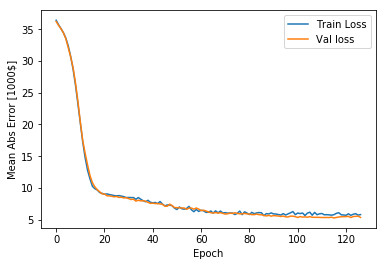

In [97]:
plot_history(history)

In [98]:
pred = model.predict(X_test)
msse(pred.flatten(), y_test)

50.817903348210194

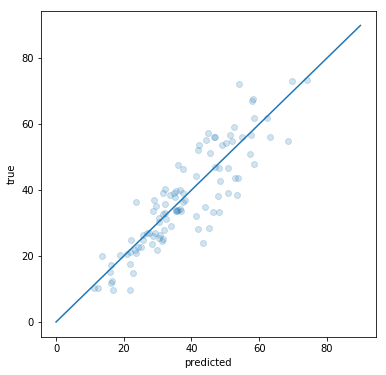

In [99]:
plot_predictions(pred, y_test)

In [100]:
weights = model.get_weights()
np.save('relu_weights', weights, allow_pickle=True)